

# Histopathological Image Classification Using Bayesian Convolutional Neural Networks

_This work was completed in Aalto University in the spring of 2019 as part of the course CS-E4890 - Deep Learning_![stockphoto](swirls_2_crop.jpeg "photo by Unsplash user @lurm")

## Section 0. Background

### Motivation
Neural networks, particularly deep neural networks, have garnered much attention from both academia and the public thanks to groundbraking results in many tasks, but they have serious deficiencies when it comes to quantifying the quality of predictions. Unpredictable behaviour, highlighted by [adversarial attacks](https://openai.com/blog/adversarial-example-research/), presents a major problem in applications where it is necessary that the system behave robustly and predictably, like medical technology. Ideally we would like the neural network to not just perform predictions, but to also provide a reliable information about the confidence of those predictions.

The aim of this project was to apply probabilistic machine learning in the form of Bayesian neural networks to classification of histopathological images in order to achive robust and reliable prediction of the presence of cancer. The probabilistic approach was chosen because medical applications of machine learning, such as diagnostic tools, require us to be able to quantify the uncertainty present in our models. 


### Bayesian neural networks
The motivation behind the development of Bayesian neural networks (BNNs) is precisely to create models that are inherently probabilistic and to allow us to get an idea about the model's confidence in its predictions. As the name suggests, BNNs are a probabilistic models that apply [Bayesian inference](https://en.wikipedia.org/wiki/Bayesian_inference) to the training procedure. While traditional neural networks learn by adjusting the weight parameters of neurons to minimize a chosen loss function, BNNs assign probability distributions to each of the weights. The following illustration by [Shridhar et al.](https://github.com/kumar-shridhar/PyTorch-BayesianCNN/tree/master/Image%20Recognition) shows this difference between traditional and Bayesian neural networks quite nicely.
![stockphoto](BayesCNNwithdist.png "photo by Unsplash user @lurm") 
BNNs learn learn by forming the posterior distribution of the weights based on the training data. What this means is that, given a likelihood function $p(\mathcal D | \mathbf w)$, the posterior distribution of the weights is given by Bayes' theorem

$$ p(\mathbf w | \mathcal D) = \frac{p(\mathcal D | \mathbf w)p(\mathbf w)}{p(\mathcal D)},$$

where $\mathcal D$ is the training data, $\mathbf w$ is a particular set of weights, and $p(\mathbf w)$ is a prior on the weights. In practice the likelihood function is some loss function, such as cross-entropy loss in the case of multi class classification, or MSE loss in the case of regression. In reality we do not calculate the exact posterior distribution, since the term $p(\mathcal D)$ is intractable. We instead use a series of clever approximations that are explained below. As the weights are described by probability distributions, the output for each sample is also in the form of probability distributions for all the classes. This posterior predictive distribution is evaluated using the formula 

$$p(y^* | \mathbf x^*) = \int p(y^* | \mathbf x^*, \mathbf w)p(\mathbf w | \mathcal D)\text d \mathbf w,$$

where $p(y^* | \mathbf x^*, \mathbf w)$ is the probability of the model with weights $\mathbf w$ assigning the label $y^*$ to unseen data example $\mathbf x^*$. Again, calculating these distributions exactly would be far too computationally intensive, or outright impossible, so we instead use clever mathematical tricks to approximate the distribution of layer activations, and draw samples to give us an estimate of the posterior predictive distribution. By sampling the activations and using them to compute multiple outputs, Bayesian neural networks are in effect a form of [ensemble learning](https://en.wikipedia.org/wiki/Ensemble_learning). This reduces overfitting and allows us to quantify the uncertainty in the predictions.

### Bayesian convolutional neural networks
Even though Bayesian neural networks were introduced all the way back in [1995](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.446.9306&rep=rep1&type=pdf), they failed to gain much popularity due to the difficulty in training them efficiently. It was only quite recently, with the introduction [Bayes by backprop ](https://arxiv.org/abs/1505.05424) (2015), the [local reparameterization trick ](https://arxiv.org/abs/1506.02557) (2015), and finally [Bayesian CNNs](https://github.com/kumar-shridhar/PyTorch-BayesianCNN/blob/master/Paper/BayesianCNN-with-VariationalInference.pdf) (2018), that deep Bayesian neural networks have become practical. 

Instead of evaluating the Bayes' theorem directly, we use a technique called [variational approximation](https://en.wikipedia.org/wiki/Variational_Bayesian_methods), or more specifically stochastic gradient variational bayes (SGVB). This involves introducing a simpler and easily parametrized distribution $q(w|\theta)$, such as multivariate Gaussian and then minimizing the difference between this approximation and the true posterior distribution $p(w|\mathcal D)$, measured using the Kullback-Leibler divergence $D_{KL}$. With this approach we can indirectly obtain a reasonably accurate approximation of the posterior distribution in a computationally efficient way. KL divergence is defined as

$$D_{KL}(q(w|\theta)\, || \, p(w| \mathcal D)) = \int q(w|\theta) \log\left(\frac{q(w|\theta)}{p(w|D)}\right) \text d w.$$

However, this is also intractable, so we reformulate the expression

$$D_{KL}(q(w|\theta)\, || \, p(w|\mathcal D)) = D_{KL}(q(w|\theta)\, || \, p(w)) - \mathbb E_{q(w|\theta)}\left[\log p(\mathcal D | w) \right] + \log p(\mathcal D).$$

This formulation is widely known as _variational free energy_. The first term depends on the prior $p(w)$ and is called the complexity cost, and the second term depends on the data $\mathcal D$ an is called the likelihood cost. The final term is constant with respect to the model parameters $\theta$ and can therefore be omitted when minimizing the expression.

Let us denote the complexity cost by $\mathcal F$ and the likelihood cost by $\mathcal L$. We can create a unbiased estimator for $\mathcal F$ by sampling the variational weight distribution $q(w|\theta)$ and computing

$$\mathcal F(\theta) \approx \sum_{i = 0}^{n} \log q((w^{(i)}| \theta) - \log p(w^{(i)}),$$

where $w^{(i)}$ are the draws. We approximate $\mathcal L$ by using the local reparameterization trick to get an unbiased and computationally efficient estimator. Normal Bayes by backpropagation reparameterizes the variational distribution as $w = f(\epsilon|\theta)$, where $f(.)$ is a differentiable function and $e \sim \mathcal N(0, 1)$. This changes the computational graph such that we can sample $\epsilon$ and calculate the gradient of the loss with respect to the variational parameters $\theta$. However this requires a very large number of computations for reasons we won't explain here. The local reparameterization trick is a improvement to this method where we use linear algebra to formulate the distribution of layer activations $\mathbf b$ and sample this instead. The full explanation is rather lengthy and not particularly relevant to the results, so please refer to the [full paper](https://arxiv.org/pdf/1506.02557.pdf) if you are interested. 

In our case the approximation of $\mathcal L$ for convolutional layers becomes

$$
\begin{split}
\mathcal L (\theta) &\approx \frac{N}{M} \sum_{i=0}^M \log p(\mathbf y^i | \mathbf x^i, w = f(\epsilon, \theta)) \\
&= \frac{N}{M} \sum_{i=0}^M \log p\left(\mathbf y^i | \mathbf b^{(i)} = A_i \mu_i + \epsilon_i \odot \sqrt{A^2 \ast (\alpha_i \odot \mu_i^2)}\right),
\end{split}
$$

where $N$ is the size of the training set, $M$ is minibatch size, m $A_i$ is the receptive field of the convolution, $\ast$ signalizes the convolutional operation and $\odot$ the component-wise multiplication. By plugging $\mathcal F$ and $\mathcal L$ back into the formula for the variational free energy, we get a full loss function that allows for backpropagation.

In the actual implementation the training proceeds by evaluating the expression twice and using stochastic gradient descent to first optimize the mean parameter of the variational distribution $\mu$, and then the variance given by $\alpha \mu^2$.

### Dataset
The data used is from a [Kaggle competition](https://www.kaggle.com/c/histopathologic-cancer-detection/overview), which is a slightly modified version of the [PCam](https://github.com/basveeling/pcam) dataset. From the PCam GitHub page:
> [The data] consists of 327 680 color images (96 x 96px) extracted from histopathologic scans of lymph node sections. Each image is annoted [sic] with a binary label indicating presence of metastatic tissue...all splits have a 50/50 balance between positive and negative examples...A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label.

When it comes to data quality and accuracy of the labels, PCam states
>All glass slides included in the CAMELYON dataset were part of routine clinical care and are thus of diagnostic quality. However, during the acquisition process, scanning can fail or result in out-of-focus images. As a quality-control measure, all slides were inspected manually after scanning. The inspection was performed by an experienced technician (Q.M. and N.S. for UMCU, M.H. or R.vd.L. for the other centers) to assess the quality of the scan; when in doubt, a pathologist was consulted on whether scanning issues might affect diagnosis.

We can therefore be confident that the data and labels are of high quality.

The Kaggle version removes duplicates and splits off 25% of the samples into a test set, which brings the number of training samples down to 220 000. The data can be downloaded [here](https://www.kaggle.com/c/histopathologic-cancer-detection/data). I used the Kaggle data, since it is provided in a convinient format, and allows results to be directly compared to the competition submissions. Since the classification is based only on the center 32 by 32 pixels of the image, we crop the samples to this area.

## Section 1. Data

In [1]:
import torch
import csv
import os
import sys
import time
import numpy as np
import math
import matplotlib.pyplot as plt
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.nn.functional as F

from PIL import Image
from torch.utils import data
from torchvision import transforms
from torchvision.transforms import ToTensor

In [106]:
plt.style.use('ggplot')

In [2]:
# csv which contains the IDs and labels for the training data
label_path = 'kaggle/train_labels.csv'

# we make a dictionary called labels, which pairs each ID with its label
with open(label_path, mode='r') as file:
    reader = csv.reader(file)
    next(reader) # skip the header
    labels = {row[0]: np.float32(row[1]) for row in reader}

# we also store all the labels in a separate list
list_IDs = list(labels.keys())

In [3]:
# we use the Torch Dataset class to handle the data
class Dataset(data.Dataset):
    def __init__(self, list_IDs, labels, transform):
        self.labels = labels
        self.list_IDs = list_IDs
        self.transform = transform
        
    def __len__(self):
        return len(self.list_IDs)
    
    def __getitem__(self, index):
        ID = self.list_IDs[index]
        filename = '{}.tif'.format(ID)
        
        filepath = os.path.join('kaggle', 'train', filename)
        image = Image.open(filepath)
        X = self.transform(image)
        y = self.labels[ID]
        
        return X, y

In [4]:
# for expariments use 20% of the samples for testing and validation and 80% for training
test_ratio = 0.1
validation_ratio = 0.1
resize = 32

# transformations applied to samples
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(), # to prevent overfitting
    transforms.CenterCrop(resize), # crop only the 32*32 center
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

training_set = Dataset(list_IDs, labels, transform=transform)

n_train = len(training_set)
indices = list(range(n_train))
# randomize the order of the samples
np.random.shuffle(indices)
test_split = int(np.floor(test_ratio * n_train))
validation_split = int(np.floor((test_ratio + validation_ratio) * n_train))

test_IDs, validation_IDs, training_IDs = indices[:test_split], \
    indices[test_split:validation_split], indices[validation_split:]

In [5]:
# change the number of workers based on your CPU
loader_params = {'batch_size': 32, 'num_workers': 6}

test_sampler = data.SubsetRandomSampler(test_IDs)
validation_sampler = data.SubsetRandomSampler(validation_IDs)
training_sampler = data.SubsetRandomSampler(training_IDs)

# torch data loaders with parallelization for efficiency
test_loader = data.DataLoader(training_set, **loader_params,
                                 sampler=test_sampler)
training_loader = data.DataLoader(training_set, **loader_params,
                                 sampler=training_sampler)
validation_loader = data.DataLoader(training_set, **loader_params,
                                 sampler=validation_sampler)

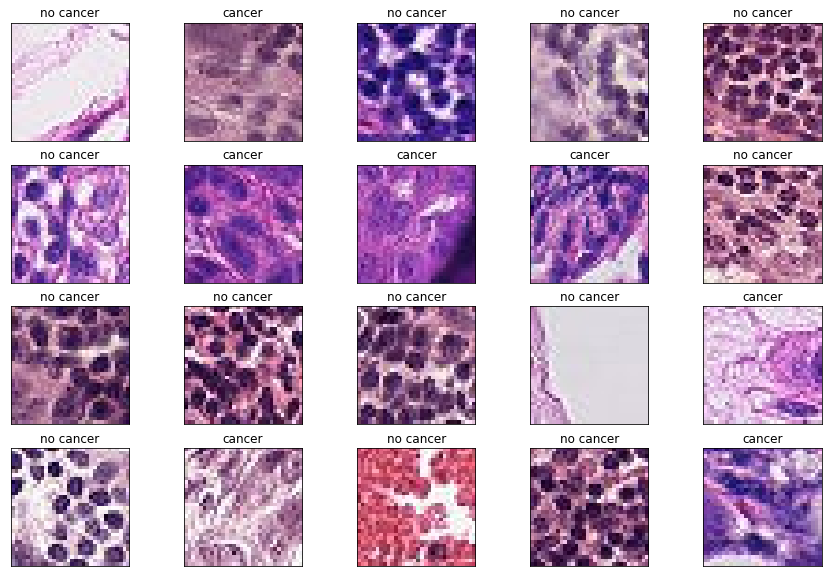

In [6]:
# we visualize a random set of training data along with labels
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

dataiter = iter(training_loader)
# obtain one batch of training images
images, labels = dataiter.next()
labels = labels.int()
classes = ['no cancer', 'cancer']

# plot a sample of 20 images from the batch along with labels
fig = plt.figure(figsize=(15, 10))
for idx in np.arange(20):
    ax = fig.add_subplot(4, 22/4, idx+1, xticks=[], yticks=[])
    
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

It can be seen that images are sometimes badly cropped as to contain very little tissue, but I assume that this does not significantly affect training performance. Furthermore, I want to have some ambiguous samples in the data so that I can experiment with how well confidence matches the misclassification rate.

## Section 2. Method

The implementation of Bayesian convolutional neural networks that I used is [PyTorch-BayesianCNN](https://github.com/kumar-shridhar/PyTorch-BayesianCNN) by Kumar Shridhar. It is built on top of the Torch neural network library to enable efficient hardware accelerated neural network training.

<div class="alert alert-block alert-info">
<b>Note:</b> The latest version (as of 18.05.2019) of at least one of the modules in the PyTorch-BayesianCNN repo have bugs in them that result in nan when calculating losses for Bayesian layers. This is a <a href="https://github.com/kumar-shridhar/PyTorch-BayesianCNN/issues/8">known issue</a> and the author has promised a fix in the future. I used version 83f5333 which I would recommend before a proper fix is issued.
</div>

In [7]:
import torch.nn as nn
from torchvision.transforms import Lambda

# if you are running the code, make sure this path is correct
sys.path.append('../PyTorch-BayesianCNN/Image Recognition/')

# the module containing the main implementation
from utils.BBBlayers import BBBConv2d, BBBLinearFactorial, FlattenLayer

I used a modified version of the LeNet architechture for experimentation due to it's limited size, which allows for relatively short training times and faster iteration on the code. Since I am performing binary classification, I use a single output with sigmoid activation for the output. The model is built in a practically identical manner to a regular Torch model. The model definition follows the template used in the BayesianCNN library. We use the same layer sizes as in round 4 of the course.

In [8]:
# modified LeNet for Bayesian binary classification

class BBCLeNet(nn.Module):
    # We allow for multiple input channels
    def __init__(self, inputs=3):
        super(BBCLeNet, self).__init__()
         
        self.conv1 = BBBConv2d(inputs,16, kernel_size=5, stride=1)
        self.soft1 = nn.Softplus()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = BBBConv2d(16, 32, kernel_size=5, stride=1)
        self.soft2 = nn.Softplus()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = FlattenLayer(5 * 5 * 32)
        self.fc1 = BBBLinearFactorial(5 * 5 * 32, 120)
        self.soft3 = nn.Softplus()

        self.fc2 = BBBLinearFactorial(120, 84)
        self.soft4 = nn.Softplus()

        self.fc3 = BBBLinearFactorial(84, 1)

        layers = [self.conv1, self.soft1, self.pool1, self.conv2, self.soft2, self.pool2,
                  self.flatten, self.fc1, self.soft3, self.fc2, self.soft4, self.fc3]

        self.layers = nn.ModuleList(layers)
        
        # Bayesian forward pass
    def probforward(self, x):
        kl = 0
        for layer in self.layers:
            # Bayesian CNN implements separate forward operations for
            # convolutional and fully connected layers
            if hasattr(layer, 'convprobforward') and callable(layer.convprobforward):
                x, _kl, = layer.convprobforward(x)
                kl += _kl

            elif hasattr(layer, 'fcprobforward') and callable(layer.fcprobforward):
                x, _kl, = layer.fcprobforward(x)
                kl += _kl
            else:
                x = layer(x)
        # limit values to the range [0, 1]
        output = torch.sigmoid(x)
        return output, kl

## Section 3. Experiments and results

For the training I used a desktop computer with an Intel i7-4790K CPU and an NVIDIA GTX 970 GPU, along with 8GB of memory.

### Building the model and training

In [9]:
skip_training = True

In [10]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
cudnn.benchmark = True

if use_cuda:
    torch.cuda.empty_cache()

print('using cuda: {}'.format(use_cuda))

using cuda: True


In [11]:
# locate the modules required for Bayesian CNNs
sys.path.append('../PyTorch-BayesianCNN/Image Recognition/')

The following is the definition of the definition of the variational loss function from the BCNN library. The additional factor `beta` is a [technical feature](https://arxiv.org/pdf/1903.07594.pdf) having to do with uncertainty.

In [12]:
class GaussianVariationalInference(nn.Module):
    def __init__(self, loss=nn.CrossEntropyLoss()):
        super(GaussianVariationalInference, self).__init__()
        self.loss = loss

    def forward(self, logits, y, kl, beta):
        logpy = -self.loss(logits, y)

        ll = logpy - beta * kl  # variational free energy loss
        loss = -ll

        return loss

In [13]:
net = BBCLeNet()

# these parameters are from the BCNN examples
lr = 0.001
weight_decay = 0.0005

net.to(device)

optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

In [14]:
max_epochs = 50
# number of samples drawn from the variational distribution
num_samples = 10

In [15]:
lr = 0.001
weight_decay = 0.0005

# we use binary cross entropy loss as the likelihood function
vi = GaussianVariationalInference(torch.nn.BCELoss())
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

In [16]:
# where to save the model during training
ckpt_name = f'model_LeNet_full_bayesian.pt'

In [17]:
%%time

if not skip_training:

    # number of input channels
    inputs = 3

    batch_size = loader_params['batch_size']

    valid_loss_min = np.Inf # track change in validation loss

    for epoch in range(1, max_epochs+1):

        # keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0

        m = math.ceil(len(training_set) / batch_size)

        # train the model
        net.train()

        for batch_idx, (data, target) in enumerate(training_loader):
            # move tensors to GPU if CUDA is available

            data = data.view(-1, inputs, resize, resize).repeat(num_samples, 1, 1, 1)

            if target.shape != torch.Size([32]):
                continue

            target = target.repeat(num_samples).view(num_samples * batch_size, -1)
            #print(target.shape)
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            # this is just from the examples
            beta = 2 ** (m - (batch_idx + 1)) / (2 ** m - 1)

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output, kl = net.probforward(data)
            # calculate the batch loss
            loss = vi(output, target, kl, beta)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss += (loss.item()*data.size(0)) / num_samples

        # validate the model 

        net.eval()
        for batch_idx, (data, target) in enumerate(validation_loader):

            data = data.view(-1, inputs, resize, resize).repeat(num_samples, 1, 1, 1)
            if target.shape != torch.Size([32]):
                continue
            raw_target = target
            target = target.repeat(num_samples).view(num_samples * batch_size, -1)
            # move tensors to GPU if CUDA is available
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output,kl = net.probforward(data)
            output = torch.sigmoid(output)

            # calculate the batch loss
            loss = vi(output, target, kl, beta)

            # update average validation loss 
            valid_loss += (loss.item()*data.size(0)) / num_samples

        train_loss = train_loss/(len(training_loader.dataset) * (1-validation_split))
        valid_loss = valid_loss/(len(validation_loader.dataset) * validation_split)

        # print training/validation statistics
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))
        #print('validation accuracy: {}'.format(valid_acc))

        # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(net.state_dict(), ckpt_name)
            valid_loss_min = valid_loss
else:
    net.load_state_dict(torch.load(ckpt_name))

CPU times: user 4.25 ms, sys: 47 µs, total: 4.3 ms
Wall time: 17.6 ms


Training was manually terminated after validation loss did not improve for seven epochs.

### Testing

For our performance benchmarks we use AUC, and how "self aware" the model is of it's confidence.

In [37]:
batch_size = loader_params['batch_size']
inputs = 3

test_samples = 100

# track test loss
test_loss = 0.0

# store true labels, mean predictions, label of mean predictions, and
# ratio of predictions for each sample from 100 draws
true_labels = np.array([])
mean_outputs = np.array([])
predicted_labels = np.array([])
prediction_ratios = np.array([])

net.eval()
#m = math.ceil(len(test_data) / batch_size)
m = math.ceil(len(validation_IDs) / batch_size)
# iterate over test data
for batch_idx, (data, target) in enumerate(test_loader):
    
    if target.shape != torch.Size([32]):
        continue
    
    true_labels = np.append(true_labels, target.numpy())
    
    data = data.view(-1, inputs, resize, resize).repeat(test_samples, 1, 1, 1)
    
    target = target.repeat(test_samples)
    # move tensors to GPU if CUDA is available
    if use_cuda:
        data, target = data.cuda(), target.cuda()
    
    beta = 2 ** (m - (batch_idx + 1)) / (2 ** m - 1)
    
    output, kl = net.probforward(data)
    loss = vi(output, target, kl, beta)
    test_loss += loss.item()*data.size(0) / test_samples
    
    output = output.view(-1, batch_size)
    
    # calculate mean prediction
    means = torch.mean(output, dim = 0)
    
    mean_outputs = np.append(mean_outputs, means.detach().cpu().numpy())
    
    transform = Lambda(lambda m: m > 0.5)
    
    predicted_labels = np.append(predicted_labels, transform(means).cpu())
    
    # then calculate ratio of predictions
    
    predictions = transform(output).float()
    ratios = torch.mean(predictions, dim = 0)
    
    prediction_ratios = np.append(prediction_ratios, ratios.cpu().numpy())

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

#print(true_labels)
#print(mean_outputs)
#print(predicted_labels)
#print(prediction_ratios)

/home/santeri/anaconda3/envs/dl-env/lib/python3.6/site-packages/torch/nn/modules/loss.py:512: UserWarning: Using a target size (torch.Size([3200])) that is different to the input size (torch.Size([3200, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Test Loss: 103.928934



### Results
For binary classification the area under the curve (AUC) is an informative and widely utilized metric. This is also the criteria used in the Kaggle competition. The top submissions in the Kaggle competition managed to achieve AUC scores of 1.0 meaning that the classifier is able to perfectly separate the two classes.

In [39]:
from sklearn.metrics import roc_auc_score, roc_curve

AUC score: 0.73


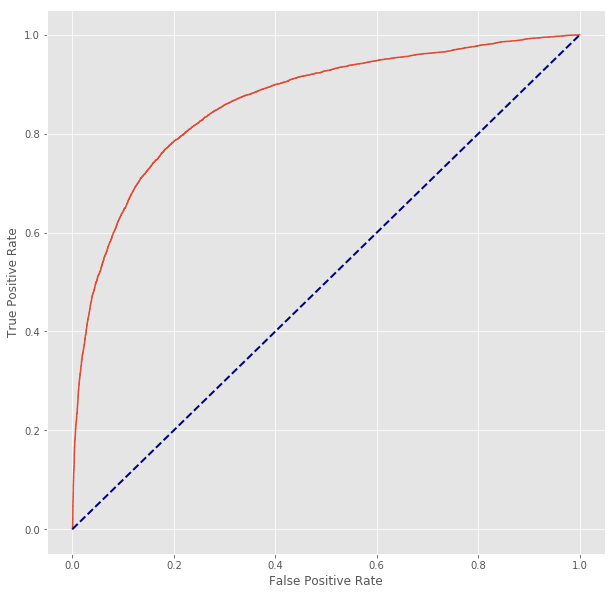

In [123]:
rocx, rocy, _ = roc_curve(true_labels, mean_outputs, drop_intermediate=False)
score = roc_auc_score(true_labels_t, mean_outputs_t)
print('AUC score: {}'.format(score))

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(rocx, rocy, label='AUC curve (area={})'.format(score))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

This AUC score leaves a lot to be desired, but is still much better than randomly assigning the classes, which corresponds to an AUC of 0.5.

Next we want to know how well the model can estimate the accuracy of it's own predictions. We do this by sampling the model output 100 times for each testing sample and using a treshold of 0.5 to classify predictions into "no cancer" and "cancer". we then the bin the prediction ratios and compare the bin values to the accuracy of using the mean prediction with the same 0.5 threshold. Ideally we would like the set of samples where the classifier produces 50/50 predictions to have low accuracy and _vice versa_.

[20349   357   229   211   154   175   158   128   131    92]


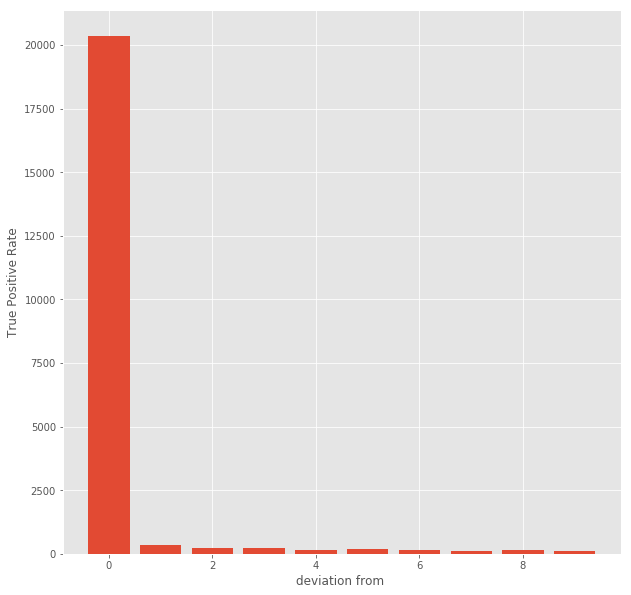

In [139]:
uncertainty = 1 - 2 * abs(prediction_ratios - 0.5)

hist, bin_edges = np.histogram(uncertainty, bins = 10)

# we check the number of samples in each bin
print(hist)

fig, ax = plt.subplots(figsize=(10,10))
ax.bar(range(10), hist)
plt.xlabel('deviation from ')
plt.ylabel('True Positive Rate')
plt.show()

It is clear that the classifier is very confident in it's predictions for the vast majority of samples, but there is also a usable number of samples with an intermediate confidence score.

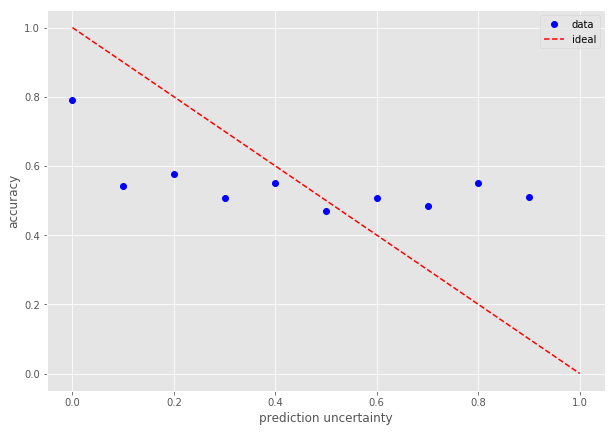

In [132]:
bin_indices = np.digitize(uncertainty, bin_edges)

accuracy_ratios = []

for i in range(1, 11):
    truths = true_labels[bin_indices == i]
    predictions = predicted_labels[bin_indices == i]
    disagreement = (1 - abs(truths - predictions)).astype(int)
    accuracy_ratio = np.mean(disagreement)
    accuracy_ratios.append(accuracy_ratio)

fix, ax = plt.subplots(figsize = (10, 7))

ax.plot(bin_edges[:-1], accuracy_ratios, 'bo')
ax.plot(bin_edges, -bin_edges + 1, 'r--')
ax.set_xlabel('prediction uncertainty')
ax.set_ylabel('accuracy')
ax.legend(labels = ['data', 'ideal'])
plt.show()

Again, this result is far from ideal but the accuracy of those samples with high confidence do indeed have significantly higher accuracy.

## Section 4. Conclusions

The results do not live up to the goal of "robust and reliable prediction of the presence of cancer", but do provide a working prototype for such a model, that could certainly be improved with further work. The model is clearly too confident in its predictions most of the time, which could be due to overfitting, bad choice of loss function, or the sigmoid squashing the outputs too aggressively. It could even be that the implementation by Shridhar is flawed in some way, since it has not seen much testing so far. More work is needed to ascertain which factors play the biggest role and how these types of models should be configured for best possible performance. Unfortunately I have hit the deadline and so this will be the conclusion of the project.

Points of future improvement might be
- a deeper net to improve the AUC
- various additional measures to reduce overfitting
- experimenting with different likelihood functions